In [11]:
file_path = '/home/krispy_noodles/SIT_Chatbot/assets/SIT_User_Study.xlsx'

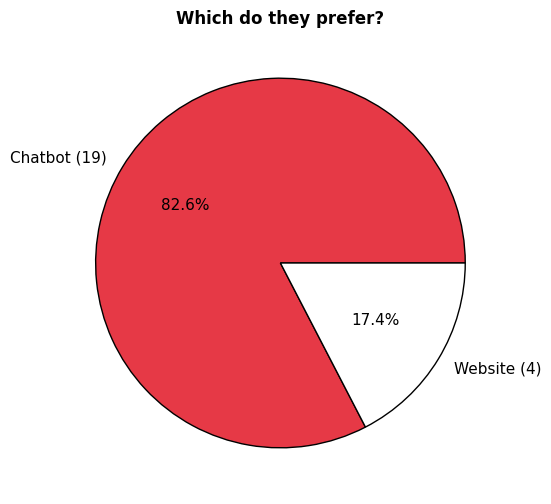

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the sheet (Replace with actual file path)
df = pd.read_excel(file_path, sheet_name='Feedback')

# Clean the DataFrame
df_cleaned = df.dropna().reset_index(drop=True)

# Standardize column names to avoid formatting issues
df_cleaned.columns = df_cleaned.columns.str.strip()

# Count unique values for preference
end_study_preference = df_cleaned["Which do they prefer?"].value_counts()

# SIT-inspired color palette
sit_colors = ['#E63946', '#FFFFFF']

# Create labels with counts and percentages
labels = [f"{label} ({count})" for label, count in zip(end_study_preference.index, end_study_preference.values)]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(end_study_preference, labels=labels, autopct='%1.1f%%', colors=sit_colors, 
        textprops={'fontsize': 11}, wedgeprops={'edgecolor': 'black'})

plt.title("Which do they prefer?", fontweight="bold")
plt.show()



In [13]:
file_path = '/home/krispy_noodles/SIT_Chatbot/assets/SIT_User_Study.xlsx'

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Load the sheet
df = pd.read_excel(file_path, sheet_name='Feedback')

# Clean the DataFrame
df_cleaned = df.dropna().reset_index(drop=True)

df_cleaned=df_cleaned[df_cleaned["Which do they prefer?"] == "Chatbot"]

# Standardize column names to avoid formatting issues
df_cleaned.columns = df_cleaned.columns.str.strip()

# Extract participant IDs and responses
participant_ids = df_cleaned.iloc[:, 0].astype(str).tolist()

responses = df_cleaned["Why (if dont wish to include too is fine)/ any comments"].astype(str).tolist()

In [14]:
from dotenv import load_dotenv
import os
from langchain_openai import OpenAIEmbeddings

# Load environment variables from the .env file
load_dotenv("/home/krispy_noodles/SIT_Chatbot/.env")

# entering the creditials
embeddings_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=os.getenv("OPENAI_API_KEY")
)

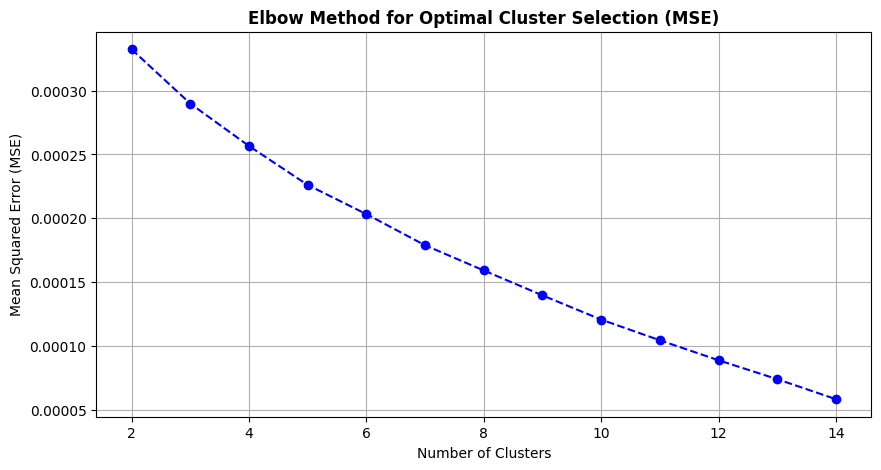

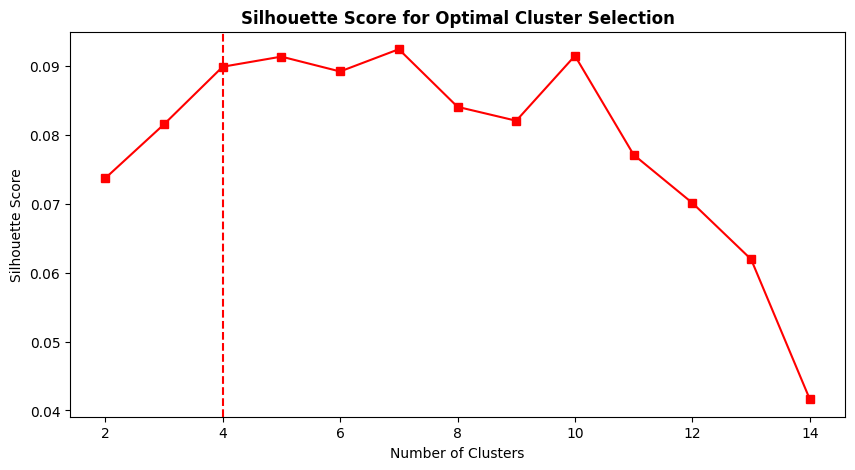

In [15]:
from langchain_openai import AzureOpenAIEmbeddings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

# Generate embeddings using Azure OpenAI
embeddings = np.array([embeddings_model.embed_query(response) for response in responses])

# Determine optimal number of clusters using the elbow method
mse_scores = []
silhouette_scores = []
cluster_range = range(2, 15)  # Checking clusters from 2 to 20

# Compute MSE for each cluster count
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    mse = mean_squared_error(embeddings, kmeans.cluster_centers_[kmeans.labels_])
    mse_scores.append(mse)
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

# Plot Elbow Method using MSE
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, mse_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Elbow Method for Optimal Cluster Selection (MSE)', fontweight="bold")
plt.grid(True)
plt.show()


# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', color='r')

# Add vertical line at x = 4
plt.axvline(x=4, color='red', linestyle='--', label='x = 4')

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Cluster Selection', fontweight="bold")
plt.show()

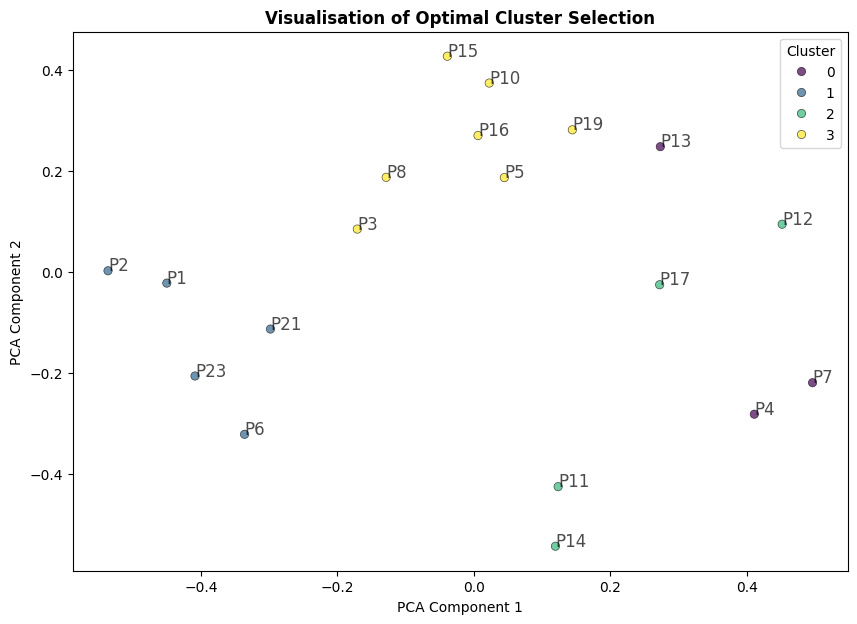

In [16]:
import seaborn as sns

# Choose optimal number of clusters (user can decide based on elbow method and silhouette score)
optimal_clusters = 4  # Change based on observation

viridis_colors_palette = ['#440154',  # Dark Purple (Cluster 0)
                  '#30678D',  # Dark Blue (Cluster 1)
                  '#35B779',  # Green/Teal (Cluster 2)
                  '#FDE724']  # Yellow (Cluster 3)

# Apply KMeans Clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(embeddings)

# Convert to DataFrame for Seaborn plotting
df_plot = pd.DataFrame({'PCA1': reduced_vectors[:, 0], 'PCA2': reduced_vectors[:, 1], 'Cluster': labels, 'Participant ID': participant_ids})

# Plot the clustered responses in 2D space with shaded clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Cluster', palette=viridis_colors_palette, alpha=0.7, edgecolor='k')

# Annotate points with participant IDs
for i, row in df_plot.iterrows():
    plt.text(row['PCA1'], row['PCA2'], row['Participant ID'], fontsize=12, alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualisation of Optimal Cluster Selection", fontweight="bold")
plt.legend(title="Cluster")
plt.show()

# Create DataFrame to display results
df_result = pd.DataFrame({'Participant ID': participant_ids, 'Response': responses, 'Cluster': labels})
df_result.sort_values(by='Cluster', inplace=True)
df_result.reset_index(drop=True, inplace=True)

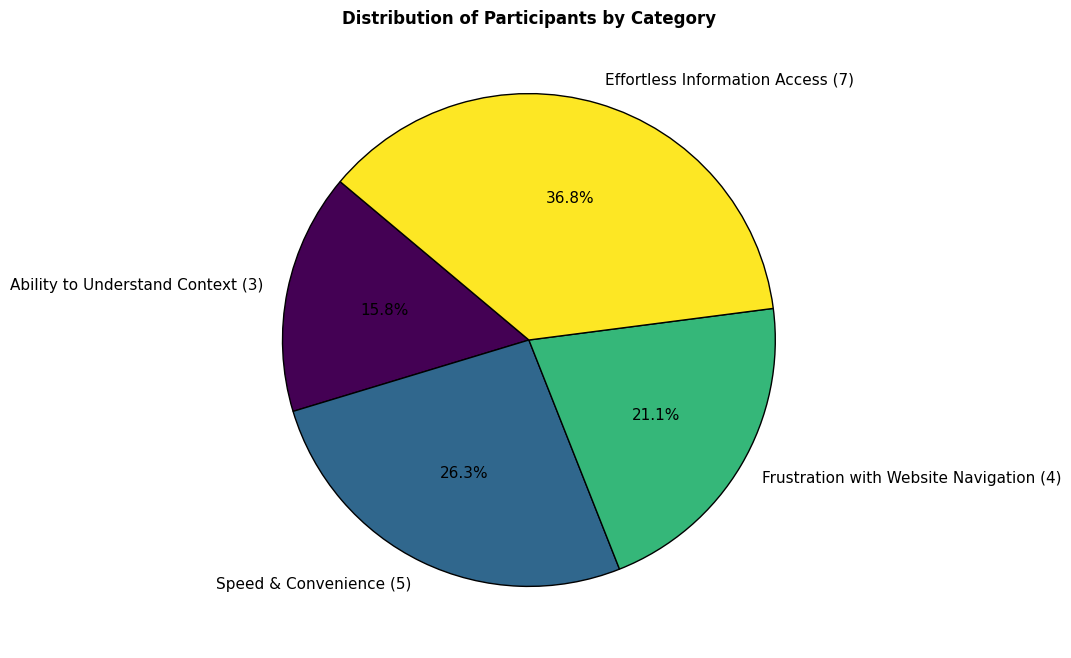

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categories mapped to clusters 0,1,2,3
unique_categories = [
    "Ability to Understand Context",  # Cluster 0
    "Speed & Convenience",            # Cluster 1
    "Frustration with Website Navigation",  # Cluster 2
    "Effortless Information Access"    # Cluster 3
]

# Count the number of people in each cluster
cluster_counts = df_result['Cluster'].value_counts().sort_index()

# Create labels with category name and count
labels = [f"{unique_categories[c]} ({count})" for c, count in zip(cluster_counts.index, cluster_counts.values)]

# Function to format percentages inside the pie chart
def autopct_format(pct):
    return f"{pct:.1f}%" if pct > 0 else ""

# Create a pie chart with percentages inside and counts beside category titles
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=labels, autopct=autopct_format, colors=viridis_colors_palette,
        startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 11})

plt.title("Distribution of Participants by Category", fontweight="bold")

# Show plot
plt.show()
